In [1]:
import atlite
import rioxarray
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import rasterio

In [2]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)

    return newcmap

In [3]:
# load cutout and gwa raster. files need to be downloaded manually
cutout=atlite.Cutout("europe-2013-era5.nc")
gwa_data=rioxarray.open_rasterio("gwa3_250_wind-speed_100m.tif")

In [6]:
# use version 1.2.9 of rasterio for the working Resampling by mean
# downsamples the gwa data to match the raster of the cutout. The resampling is done with averaging the wind speed.
ds=gwa_data.sel(band=1, x=slice(*cutout.extent[[0,1]]), y=slice(*cutout.extent[[3,2]]))
ds=ds.where(ds!=-999)
ds=atlite.gis.regrid(ds,cutout.data.x, cutout.data.y,resampling=rasterio.warp.Resampling.average)

In [ ]:
fig, ax=plt.subplots(1,3, figsize=(20,10))

cutout.data.wnd100m.mean("time").plot(ax=ax[0], vmin=0, vmax=15)

ds.plot(ax=ax[1], vmin=0, vmax=15)

newcmap=shiftedColorMap(cmap=matplotlib.cm.PiYG, start=0, stop=1, midpoint=0.5)
# gwa wind speed mean divided by cutout wind speed mean -> corresponds to the bias correction factor
(ds/cutout.data.wnd100m.mean("time")).plot(ax=ax[2], cmap=newcmap, vmax=2, vmin=0)

ax[0].set_title("era5")
ax[1].set_title("gwa3.1")
ax[2].set_title("ratio gwa3.1/era5")

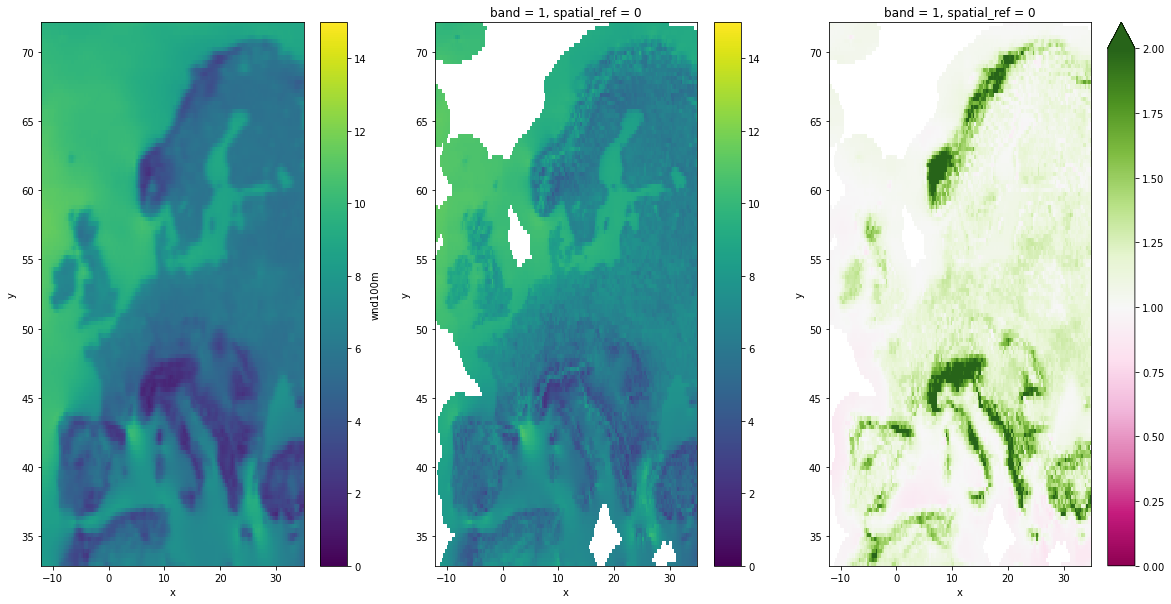

In [10]:
fig

In [14]:
(ds/cutout.data.wnd100m.mean("time")).mean().compute()

<xarray.DataArray ()>
array(1.17000696)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

In [15]:
fig.savefig("gwa_era5.pdf", dpi=400, facecolor='white')